### 14.2 가중치 감쇠
- 원래 손실함와 함께 L2 노름을 같이 최소화하도록 하여 모델의 학습을 방해하는 형태로 동작
- 학습을 진행하면 (1)번 항을 최소화함 → 손실을 줄이는 가중치(W)는 커지게 되므로 L2값인 (2)번 텀은 커지게 되어 전체 손실이 최소화되는 것을 방해함
    - 일반적으로 오버피팅은 가중치가 너무 커져서 발생 → 큰 가중치에 큰 패널티 부과하여 오버피팅 방지
- 파이토치에서는 optimizer의 설정으로 구현

### 14.3 데이터 증강
#### 이미지 증강 기법
#### 텍스트 증강 기법

### 14.3 드롭아웃
- 데이터 증강 기법 → 신경망의 입력 또는 출력 위치에 노이즈를 추가하는 것으로 볼 수 있음
- 드롭아웃 → 신경망의 중간에 노이즈 추가 효과
    - 임의의 노드를 일정 확률로 드롭해서 학습에 참여하지 않도록 하는 방법
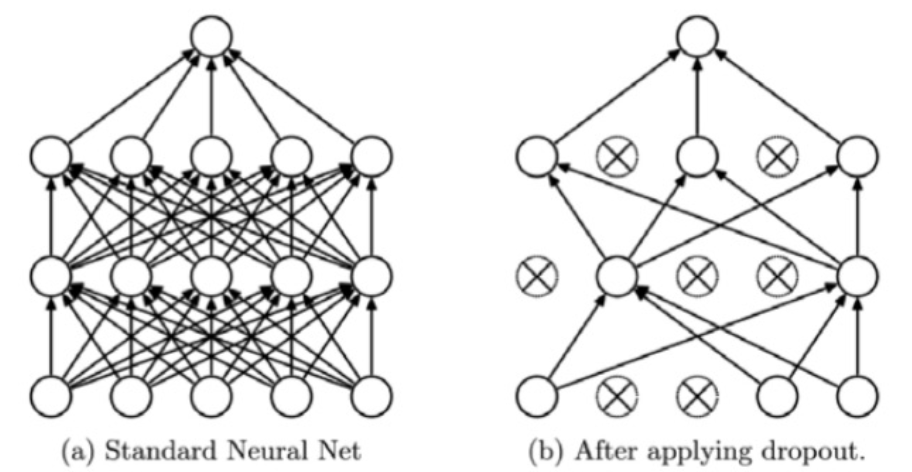
#### 학습과 추론 방식의 차이
- 드롭아웃은 학습에만 적용: 학습하는 신경망에 노이즈 추가
- 가중치에 (1-p)만큼 곱함
    - 학습할 때 p만큼의 확률로 드롭아웃을 하면 다음 계층으로는 넘어가는 값은 드롭아웃을 하지 않을 때에 비하여 (1-p)배 크기로 작아지게 함
    - 파이토치에서는 반대로 학습할 때 미리 (1-p) 만큼 나누어줌으로써 드롭아웃을 하지 않았을 때의 값을 크기로 환원시켜 주고, 추론할 때는 그냥 계산을 하도록 함
#### 드롭아웃 구현
- 활성함수와 다음 계층의 구현
#### 드롭아웃의 장단점
장점: 일반화 성능 개선
단점
- 손실값 수렴 속도 저하
- 학습 오차 증가
- 드롭아웃 확률값(p)이 새로운 하이퍼파라미터로 추가

### 14.5 배치 정규화
- 공변량 변화 문제 해결을 위해 제안
    - 공변량 문제, 둘 이상의 독립변수 또는 종속변수에 의해 결과가 영향을 받는 문제
    - 역전파로 파라미터 업데이트를 하여 최적화가 진행되었는데, 다음 입력 데이터는 이전 데이터와 다른 데이터이므로 최적화에 역행하는 출력을 산출할 수 있고 이것이 다음 계층으로 넘어가면서 다른 뉴런에 영향을 주게 됨
    - 이것이 공변량 문제로 인식될 수 있음
    - 미니배치 분포를 정규화하여 해결
- 장점
    - 튜닝이 필요한 하이퍼파라미터가 추가되지 않음
    - 학습 속도 향상 + 일반화 성능 개선
- 한계
    - 동작 원리가 밝혀지지 않았음
    - 미니배치 크기가 적당해야 좋음
#### 배치 정규화의 표현
- 논물 제시: 활성 계층앞에 위치
- 많은 경우: 드롭아웃 대신 사용하는 경우가 많아서 활성계층 다음에 위치
### 14.6 실습

In [1]:
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torchvision import datasets, transforms

train = datasets.MNIST(
    '../data', train=True, download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

test = datasets.MNIST(
    '../data', train=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
    ]),
)

In [2]:
x = train.data.float() / 255.
y = train.targets

x = x.view(x.size(0), -1) # 꼭 0 넣기
print(x.shape, y.shape)

input_size = x.size(-1)
output_size = int(max(y)) + 1

print('input_size: %d, output_size: %d' % (input_size, output_size))

torch.Size([60000, 784]) torch.Size([60000])
input_size: 784, output_size: 10


In [3]:
# Train / Valid ratio
ratios = [.8, .2]

train_cnt = int(x.size(0) * ratios[0])
valid_cnt = int(x.size(0) * ratios[1])
test_cnt = len(test.data)
cnts = [train_cnt, valid_cnt]

print("Train %d / Valid %d / Test %d samples." % (train_cnt, valid_cnt, test_cnt))

indices = torch.randperm(x.size(0))

x = torch.index_select(x, dim=0, index=indices)
y = torch.index_select(y, dim=0, index=indices)

x = list(x.split(cnts, dim=0))
y = list(y.split(cnts, dim=0))

x += [(test.data.float() / 255.).view(test_cnt, -1)]
y += [test.targets]

for x_i, y_i in zip(x, y):
    print(x_i.size(), y_i.size())

Train 48000 / Valid 12000 / Test 10000 samples.
torch.Size([48000, 784]) torch.Size([48000])
torch.Size([12000, 784]) torch.Size([12000])
torch.Size([10000, 784]) torch.Size([10000])


In [10]:
# 모델 정의 
class Block(nn.Module):

    def __init__(
        self,
        input_size,
        output_size,
        use_batch_norm=True,
        dropout_p=.4
    ):
        self.input_size = input_size
        self.output_size = output_size
        self.use_batch_norm = use_batch_norm
        self.dropout_p = dropout_p

        super().__init__()

        def get_regularizer(use_batch_norm, size):
            return nn.BatchNorm1d(size) if use_batch_norm else nn.Dropout(dropout_p)

        self.block = nn.Sequential(
            nn.Linear(input_size, output_size),
            nn.LeakyReLU(),
            get_regularizer(use_batch_norm, output_size),
        )

    def forward(self, x):
        y = self.block(x)
        return y

In [11]:
class MyModel(nn.Module):

    def __init__(
        self,
        input_size,
        output_size,
        use_batch_norm=True,
        dropout_p=.4
    ):
        super().__init__()

        self.layers = nn.Sequential(
            Block(input_size, 500, use_batch_norm, dropout_p),
            Block(500, 400, use_batch_norm, dropout_p),
            Block(400, 300, use_batch_norm, dropout_p),
            Block(300, 200, use_batch_norm, dropout_p),
            Block(200, 100, use_batch_norm, dropout_p),
            Block(100, 50, use_batch_norm, dropout_p),
            nn.Linear(50, output_size),
            nn.LogSoftmax(dim=-1), # 분류 
        )

    def forward(self, x):
        y = self.layers(x)
        return y

In [9]:
# 모델 선언 및 출력
model = MyModel(
    input_size,
    output_size,
    use_batch_norm=True
)

print(model)

MyModel(
  (layers): Sequential(
    (0): Block(
      (block): Sequential(
        (0): Linear(in_features=784, out_features=500, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Block(
      (block): Sequential(
        (0): Linear(in_features=500, out_features=400, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): Block(
      (block): Sequential(
        (0): Linear(in_features=400, out_features=300, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (3): Block(
      (block): Sequential(
        (0): Linear(in_features=300, out_features=200, bias=True)
        (1): LeakyReLU(negative_slope=0.01)
        (2): BatchNorm1d(200, e

In [13]:
optimizer = optim.Adam(model.parameters())
crit = nn.NLLLoss()

device = torch.device("cpu")
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available(): 
    device = torch.device("mps")

model = model.to(device)

x = [x_i.to(device) for x_i in x]
y = [y_i.to(device) for y_i in y]

In [15]:
n_epochs = 1000
batch_size = 256
print_interval = 10

lowest_loss = np.inf
best_model = None

early_stop = 50
lowest_epoch = np.inf

train_history, valid_history = [], []

for i in range(n_epochs):
    model.train() # 학습 설정

    indices = torch.randperm(x[0].size(0)).to(device)
    x_ = torch.index_select(x[0], dim=0, index=indices)
    y_ = torch.index_select(y[0], dim=0, index=indices)

    x_ = x_.split(batch_size, dim=0)
    y_ = y_.split(batch_size, dim=0)

    train_loss, valid_loss = 0, 0
    y_hat = []

    for x_i, y_i in zip(x_, y_):
        y_hat_i = model(x_i)
        loss = crit(y_hat_i, y_i.squeeze())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += float(loss)

    train_loss = train_loss / len(x_)

    model.eval() # 검증 설정: dropout 때문에 설정 필요
    with torch.no_grad():
        x_ = x[1].split(batch_size, dim=0)
        y_ = y[1].split(batch_size, dim=0)

        valid_loss = 0

        for x_i, y_i in zip(x_, y_):
            y_hat_i = model(x_i)
            loss = crit(y_hat_i, y_i.squeeze())
            valid_loss += float(loss)

        valid_loss = valid_loss / len(x_)

        loss = crit(y_hat_i, y_i.squeeze())
        valid_loss += float(loss)

        y_hat += [y_hat_i]

    valid_loss = valid_loss / len(x_)

    train_history += [train_loss]
    valid_history += [valid_loss]

    if (i + 1) % print_interval == 0:
        print(
            'Epoch %d: train_loss=%.4e  valid_loss=%.4e  lowest_loss=%.4e' % (
                i + 1,
                train_loss,
                valid_loss,
                lowest_loss,
            )
        )

    if valid_loss <= lowest_loss:
        lowest_loss = valid_loss
        lowest_epoch = i

        best_model = deepcopy(model.state_dict())
    else:
        if early_stop > 0 and lowest_epoch + early_stop < i + 1:
            print("There is no improvement during last %d epochs." % early_stop)
            break

print("The best validation loss from epoch %d: %.4e" %
      (lowest_epoch + 1, lowest_loss))

model.load_state_dict(best_model)

/var/folders/4n/bn2y9j953s9cm6hn2_vxqphm0000gn/T/ipykernel_55764/2897835652.py:34: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:836.)
  train_loss += float(loss)


Epoch 10: train_loss=2.4963e-02  valid_loss=2.5907e-03  lowest_loss=2.5748e-03
Epoch 20: train_loss=1.3733e-02  valid_loss=4.6312e-03  lowest_loss=2.0668e-03
Epoch 30: train_loss=1.0810e-02  valid_loss=2.6758e-03  lowest_loss=1.9919e-03
Epoch 40: train_loss=5.2797e-03  valid_loss=2.2964e-03  lowest_loss=1.9919e-03
Epoch 50: train_loss=4.6512e-03  valid_loss=2.2031e-03  lowest_loss=1.9919e-03
Epoch 60: train_loss=5.2961e-03  valid_loss=2.5058e-03  lowest_loss=1.9919e-03
Epoch 70: train_loss=5.1658e-03  valid_loss=3.0865e-03  lowest_loss=1.8013e-03
Epoch 80: train_loss=2.6085e-03  valid_loss=2.7976e-03  lowest_loss=1.8013e-03
Epoch 90: train_loss=4.1140e-03  valid_loss=3.8359e-03  lowest_loss=1.8013e-03
Epoch 100: train_loss=2.1411e-03  valid_loss=4.0390e-03  lowest_loss=1.8013e-03
Epoch 110: train_loss=2.0858e-03  valid_loss=2.6228e-03  lowest_loss=1.8013e-03
There is no improvement during last 50 epochs.
The best validation loss from epoch 69: 1.8013e-03


<All keys matched successfully>

#### 용도 구별
- model.train()
    - forward 연산
    - Batch Normalization Layer - batch statistics를 이용하여 연산
    - Dropout Layer: 주어진 비율로 활성화
    - backward 연산 가능
- model.eval()
    - forward 연산
    - Batch Normalization Layer > 학습에서 결정된 running statistics로 연산
    - Dropout Layer: 비활성화
    - backward 연산 가능
- model.no_grad()
    - forward 연산
    - Batch Normalization Layer- batch statistics를 이용하여 연산
    - autograd 연산 비활성화 -> backward 연산 불가 -> 메모리 효율성 향상, 속도 향상
- required_grad = False
    - 설정한 파라미터는 gradient 연산을 하지 않음
    - model.no_grad()는 전체 파라미터의 gradient 연산을 하지 않는 것에 반해, 설정한 파라미터만 gradient 연산을 하지 않음
    - model.no_grad()는 autograd 엔진이 비활성화되기 때문에 gradient를 저장하지 않지만, 이 경우에는 연산만 하지 않을 뿐 gradient를 저장함: 모델의 특정 부분 즉, 필요로 하는 것만 멈출(freeze) 수 있음
    - 모델의 특정 부분을 freeze시키고 나머지 부분만 학습시키는 역할 수행

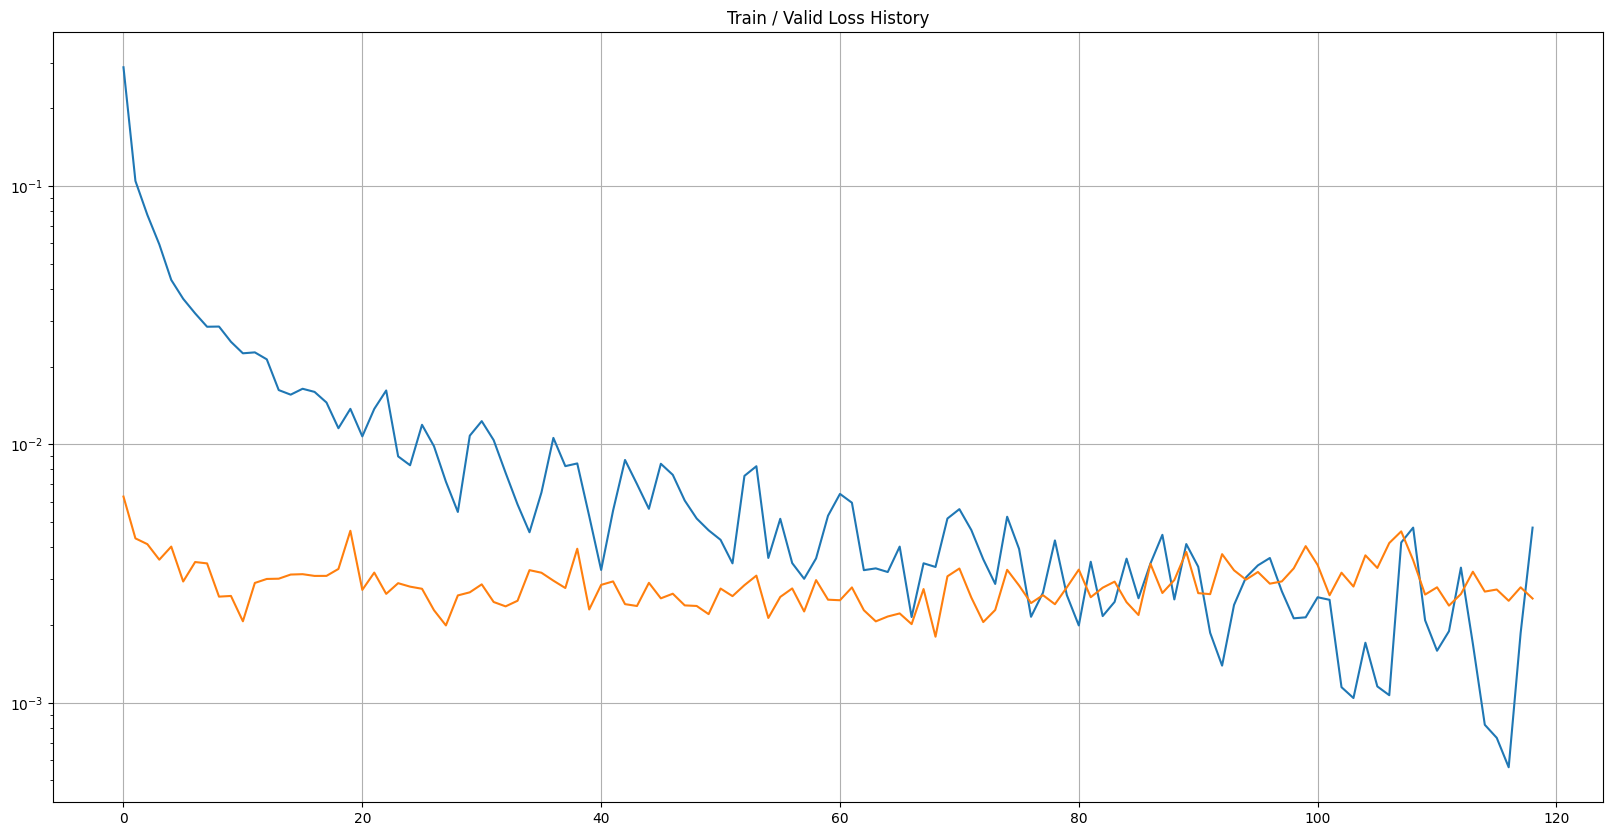

In [16]:
plot_from = 0

plt.figure(figsize=(20, 10))
plt.grid(True)
plt.title("Train / Valid Loss History")
plt.plot(
    range(plot_from, len(train_history)), train_history[plot_from:],
    range(plot_from, len(valid_history)), valid_history[plot_from:],
)
plt.yscale('log')
plt.show()

## 15. 실무 환경에서의 프로젝트 연습
#### 머신러닝 프로젝트 파일 구조
- model.py: 모델 클래스 정의
- trainer.py: 모델 학습을 위한 트레이터 정의
- dataload.py: 데이터 로딩, 전처리 수행
- train.py: 하이퍼파라미터를 입력받아서 학습 진행
- predict.py: 학습된 모델과 추론용 샘플을 입력받아서 추론 수행
- 
#### 알고리즘 적용
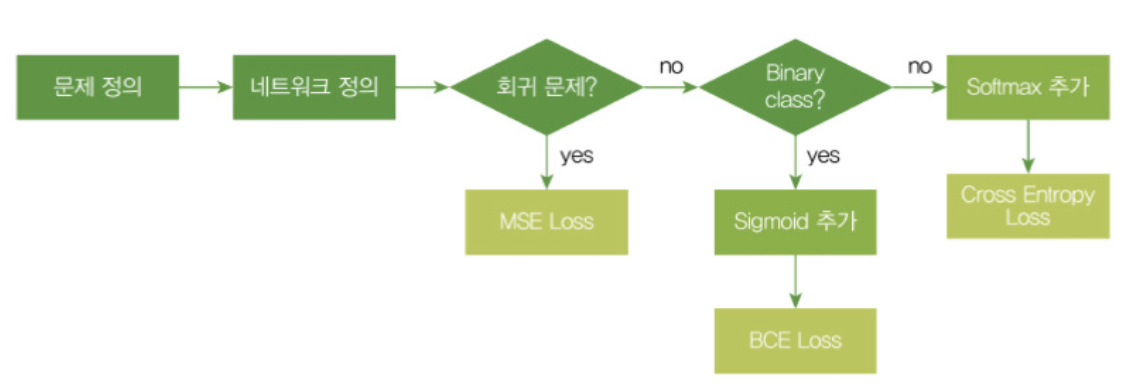

